<a href="https://colab.research.google.com/github/ishikaarora/adversarial-attacks-and-defenses/blob/master/train_proxy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Author: Ishika Arora
# PyTorch Transfer Learning example (ResNet50 trained on ImageNet 2012 dataset)

In [0]:
from __future__ import print_function, division
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [0]:
BATCH_SIZE = 16
log_frequency = 500

In [0]:
# mean color of training images
# cifar10_mean = [0.49131522, 0.48209435, 0.44646862]
# # std dev of color across training images
# cifar10_std = [0.01897398, 0.03039277, 0.03872553]

cifar10_mean = [0.49139968 , 0.48215841 , 0.44653091]
cifar10_std = [0.24703223,  0.24348513 , 0.26158784]

# cifar10_mean = [0.4914, 0.4822, 0.4465]
# cifar10_std = [0.2023, 0.1994, 0.2010]

In [0]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean,cifar10_std)
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean,cifar10_std)
])

cifar_dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform= transform_train)

trainset = cifar_dataset
valset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform= transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_size = len(trainset)
val_size = len(valset)
print(val_size)
print(train_size)

10000
50000


In [0]:
class_names = cifar_dataset.classes
len(class_names)

10

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



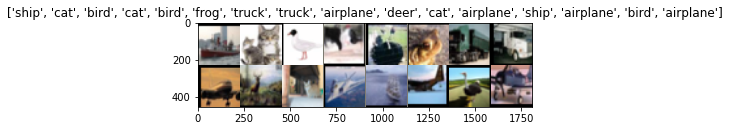

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = cifar10_std * inp + cifar10_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

This is the general function to train the model, which does two things:

-  Scheduling the learning rate
-  Saving the best model


In [0]:
def evaluate_model(model, loader, n_batches=None):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_i, data in enumerate(loader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels)
            _,predicted = torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            
            if n_batches and (batch_i >= n_batches):
              break
            
    loss /= total
    acc = 100. * correct / total
    return loss, acc, total

In [0]:
def train_model(criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        start = time.time()
        
        # Model Training step
        scheduler.step()
        model.train()  # Set model to training mode
            
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            
            if (batch_idx+1) % log_frequency == 0:
                examples_this_epoch = (batch_idx+1) * len(inputs)
                epoch_progress = 100. * (batch_idx+1) / len(trainloader)
                
                train_loss = running_loss / examples_this_epoch
                train_acc = 100. * running_corrects.double() / examples_this_epoch

                val_loss, val_acc, val_size = evaluate_model(model, valloader, n_batches=9)

                # for plotting losses later
                train_losses.append(train_loss)
                train_accs.append(train_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)
      
                print('Epoch: {} [{}/{} ({:.0f}%)]\t'
                      'Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}, Val Size: {}'.format(
                    epoch+1, examples_this_epoch, train_size,
                    epoch_progress, train_loss, train_acc, val_loss, val_acc, val_size))

                # deep copy the best model
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model_wts = copy.deepcopy(model.state_dict())            
            
        time_taken = (time.time()-start) / 60
        print("Epoch: {} finished | Time taken: {}".format(epoch+1, time_taken))
          
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    # torch.save(model, 'mymodel' + '.pt')

    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Load pretrained model

In [0]:
start_time = time.time()
model_res = models.resnet18(pretrained=True)
print('Time to load the model: {:10f} seconds'.format((time.time()-start_time)))

Time to load the model:   0.252571 seconds


ConvNet as fixed feature extractor
----------------------------------

We freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

More about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
for param in model_res.parameters():
    param.requires_grad = False

num_ftrs = model_res.fc.in_features
model_res.fc = nn.Linear(num_ftrs, 10)

model = model_res.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []

In [0]:
proxy_model = train_model(criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1 [8000/50000 (16%)]	Train Loss: 0.0811, Train Acc: 58.1125, Val Loss: 0.0560, Val Acc: 68.7500, Val Size: 160
Epoch: 1 [16000/50000 (32%)]	Train Loss: 0.0648, Train Acc: 66.5687, Val Loss: 0.0486, Val Acc: 70.6250, Val Size: 160
Epoch: 1 [24000/50000 (48%)]	Train Loss: 0.0582, Train Acc: 69.7333, Val Loss: 0.0462, Val Acc: 75.6250, Val Size: 160
Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.0541, Train Acc: 71.5750, Val Loss: 0.0475, Val Acc: 71.8750, Val Size: 160
Epoch: 1 [40000/50000 (80%)]	Train Loss: 0.0519, Train Acc: 72.4175, Val Loss: 0.0468, Val Acc: 73.7500, Val Size: 160
Epoch: 1 [48000/50000 (96%)]	Train Loss: 0.0502, Train Acc: 73.1917, Val Loss: 0.0451, Val Acc: 76.2500, Val Size: 160
Epoch: 1 finished | Time taken: 1.3763028224309286
Epoch 2/5
----------
Epoch: 2 [8000/50000 (16%)]	Train Loss: 0.0464, Train Acc: 74.0750, Val Loss: 0.0415, Val Acc: 78.7500, Val Size: 160
Epoch: 2 [16000/50000 (32%)]	Train Loss: 0.0433, Train Acc: 75.8937, Val Loss: 0.0455, Val Acc: 7

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
torch.save(proxy_model, 'myproxymodel_resnet' + '.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
loss, acc, total = evaluate_model(proxy_model, valloader)

In [0]:
print(loss, acc, total)

tensor(0.0388, device='cuda:0') 79.04 10000


In [0]:
loss, acc, total = evaluate_model(model, valloader)
print(loss, acc, total)

tensor(0.0390, device='cuda:0') 78.42 10000


In [0]:
model.parameters() == proxy_model.parameters()

False